### TODO Recording:

- Please upload the fra.txt file to Colab

https://edumunozsala.github.io/BlogEms/fastpages/jupyter/encoder-decoder/lstm/attention/tensorflow%202/2020/10/07/Intro-seq2seq-Encoder-Decoder-ENG-SPA-translator-tf2.html

In [5]:
pip install "tensorflow-text>=2.11"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.9 MB/s eta 0:00:00


Required Libraries and modules are imported

In [6]:
import string
import random

import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

Loading the data and then generating sentence pairs in tuple form.

In [10]:
with open("fra.txt") as f:
    lines = f.read().split("\n")[:-1]

    text_pairs = []

    for line in lines:
        eng, fra = line.split("\t")
        fra = "[start] " + fra + " [end]"
        text_pairs.append((eng, fra))

Viewing some eng-french sentence pairs

In [11]:
for _ in range(10):
    print(random.choice(text_pairs))

('You had a long day.', '[start] Vous avez eu une longue journée. [end]')
('It was a warm day, so we went swimming.', "[start] C'était une chaude journée donc nous sommes allés nager. [end]")
('I spend at least three hours a week studying French.', "[start] J'ai passé au moins trois heures par semaine à étudier le français. [end]")
("It won't cost you a dime.", '[start] Ça ne te coûtera pas un centime. [end]')
('Tom makes everyone nervous.', '[start] Tom rend tout le monde nerveux. [end]')
('I felt sad.', '[start] Je me suis sentie triste. [end]')
("Don't cast pearls before swine.", '[start] Ne donnez pas de la confiture aux cochons. [end]')
("That's completely unfair.", "[start] C'est totalement injuste. [end]")
('Where is it located?', '[start] Où est-ce que ça se trouve ? [end]')
('They forgot to lock the door.', '[start] Ils oublièrent de fermer la porte à clé. [end]')


Splitting whole text pairs list into training, validation and test pairs

In [12]:
random.shuffle(text_pairs)

num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

167130 total pairs
116992 training pairs
25069 validation pairs
25069 test pairs


The text sentences are almost clean, they are simple plain text, so we only need to remove accents, lower case the sentences and replace everything with space except (a-z, A-Z, ".", "?", "!", ","). Function for text cleaning is defined

In [13]:
def tf_lower_and_split_punct(text):

    """
      Processes text before vectorization.
    """
    # French text contains special symbols. Unicode normalization:
    text = tf_text.normalize_utf8(text, "NFKD")

    # Lowercase
    text = tf.strings.lower(text)

    # Keep space, a to z, and select punctuation and square brackets.
    text = tf.strings.regex_replace(text, "[^ a-z.?!,\]\[]", "")

    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, "[.?!,]", r" \0 ")

    # Strip whitespace.
    text = tf.strings.strip(text)

    return text

Vectorizing the text data
Using two instances of the TextVectorization layer to vectorize the text data (one for English and one for French), that is to say, to turn the original strings into integer sequences where each integer represents the index of a word in a vocabulary.

Both English and French  layer will use our custom standardization defined above.

All inputs will be of the same length -

*output_sequence_length*

Only valid in INT mode. If set, the output will have its time dimension padded or truncated to exactly output_sequence_length values, resulting in a tensor of shape (batch_size, output_sequence_length) regardless of how many tokens resulted from the splitting step. Defaults to None.

`sequence_length + 1` is to shift words by 1 for next word prediction

In [14]:
vocab_size = 15000
sequence_length = 20
batch_size = 64

eng_vectorization = TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length,
    standardize = tf_lower_and_split_punct
)

fra_vectorization = TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length + 1,
    standardize = tf_lower_and_split_punct,
)


Creating both eng and french vocabularies using training data

In [15]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]

eng_vectorization.adapt(train_eng_texts)
fra_vectorization.adapt(train_fra_texts)

Checking the english vocabulary

In [16]:
vocab_inp_size = len(eng_vectorization.get_vocabulary())

vocab_inp_size

12692

In [17]:
eng_vectorization.get_vocabulary()[:15]

['',
 '[UNK]',
 '.',
 'i',
 'you',
 'to',
 'the',
 '?',
 'a',
 'is',
 'tom',
 'that',
 'he',
 'do',
 'of']

Checking the french vocabulary

In [18]:
vocab_out_size = len(fra_vectorization.get_vocabulary())

vocab_out_size

15000

In [19]:
fra_vectorization.get_vocabulary()[:15]

['',
 '[UNK]',
 '[start]',
 '[end]',
 '.',
 'je',
 'de',
 'a',
 '?',
 'pas',
 'que',
 'la',
 'ne',
 'le',
 'vous']

Next, formatting our datasets.

At each training step, the model will seek to predict target words N+1 (and beyond) using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple (inputs, targets), where:

- inputs is a dictionary with the keys encoder_inputs and decoder_inputs.
- encoder_inputs is the vectorized source sentence and decoder_inputs is the target sentence "so far", that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.
- target is the target sentence offset by one step: it provides the next words in the target sentence — what the model will try to predict.

In [20]:
import tensorflow as tf

def format_dataset(eng, fra):
    eng = eng_vectorization(eng)
    fra = fra_vectorization(fra)

    # (english tokens, french tokens, french tokens shifted by 1)
    return eng, fra[:, :-1], fra[:, 1:]

def make_dataset(pairs):
    eng_texts, fra_texts = zip(*pairs)

    eng_texts = list(eng_texts)
    fra_texts = list(fra_texts)

    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fra_texts))

    dataset = dataset.batch(batch_size, drop_remainder = True)

    dataset = dataset.map(format_dataset)

    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
test_ds = make_dataset(test_pairs)

In [21]:
encoder_inputs, decoder_inputs, targets = next(iter(train_ds))

encoder_inputs.shape, decoder_inputs.shape, targets.shape

(TensorShape([64, 20]), TensorShape([64, 20]), TensorShape([64, 20]))

Checking the inputs and targets..Note that target is offset by one step from decoder_inputs

In [22]:
encoder_inputs

<tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[  44,  246, 1082, ...,    0,    0,    0],
       [  12,  463,   42, ...,    0,    0,    0],
       [  28,  122,  205, ...,    0,    0,    0],
       ...,
       [ 155,   10,  145, ...,    0,    0,    0],
       [ 757,   14,  164, ...,    0,    0,    0],
       [   5,   78,    6, ...,    0,    0,    0]])>

In [23]:
decoder_inputs

<tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[   2,  166,    9, ...,    0,    0,    0],
       [   2,   15,  512, ...,    0,    0,    0],
       [   2,    5,   29, ...,    0,    0,    0],
       ...,
       [   2,   92,   10, ...,    0,    0,    0],
       [   2,   11, 1017, ...,    0,    0,    0],
       [   2,    7,   85, ...,    0,    0,    0]])>

In [24]:
targets

<tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[ 166,    9, 1806, ...,    0,    0,    0],
       [  15,  512,   47, ...,    0,    0,    0],
       [   5,   29,  392, ...,    0,    0,    0],
       ...,
       [  92,   10,   16, ...,    0,    0,    0],
       [  11, 1017,  705, ...,    0,    0,    0],
       [   7,   85,  318, ...,    0,    0,    0]])>

The encoder

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep

Layers of recurrent units where in each time step, receive a an input token, collects relevant information and produce a hidden state. Depends on the type of RNN, in our example a LSTM, the unit "mixes" the current hidden state and the input and return an output, discarded, and a new hidden state.

Encoder vector is the last hidden state of the encoder and it tries to contain as much of the useful input information as possible to help the decoder get the best results. It is only information from the input that the decoder will get.

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()

        self.hidden_dim = hidden_dim

        # Define the embedding layer
        self.embedding = layers.Embedding(vocab_size, embedding_dim)

        # Define the RNN layer with LSTM cells
        self.lstm = layers.LSTM(
            hidden_dim, return_sequences = True, return_state = True)

    def call(self, input_sequence, states):

        # Input shape: (batch_size, sequence_length)

        # Embed the input
        embed = self.embedding(input_sequence)

        # Embed shape: (batch_size, sequence_length, embedding_dim)

        # Call the LSTM unit
        output, state_h, state_c = self.lstm(embed, initial_state = states)

        # Output shape: (batch_size, sequence_length, hidden_dim)
        # state_h shape: (batch_size, hidden_dim)
        # state_c shape: (batch_size, hidden_dim)

        return output, state_h, state_c

    def init_states(self, batch_size):

        # Return all 0s initial states
        return (
            tf.zeros([batch_size, self.hidden_dim]),
            tf.zeros([batch_size, self.hidden_dim])
        )

 We have included a simple test, calling the encoder and decoder to check they works fine.

In [26]:
embedding_dim = 128
hidden_units = 256

# Create the Encoder
encoder = Encoder(vocab_inp_size, embedding_dim, hidden_units)

# Getting initial states
initial_state = encoder.init_states(batch_size = 1)

# Call the encoder for testing
test_encoder_output = encoder(tf.constant(
    [[1, 5, 10, 15, 20, 25]]), initial_state)

# outputs, state_h, state_c
test_encoder_output[0].shape, test_encoder_output[2].shape, test_encoder_output[2].shape

(TensorShape([1, 6, 256]), TensorShape([1, 256]), TensorShape([1, 256]))

Decoder network without Attention.
Layers of recurrent units, i.e. LSTMs, where each unit produces an output at a time step t. The hidden state of the first unit is the encoder vector and the rest of units accept the hidden state from the previous unit. The output is calculated using a softmax function to obtain a probability for every token in the output vocabulary.

In [27]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()

        self.hidden_dim = hidden_dim

        # Define the embedding layer
        self.embedding = layers.Embedding(vocab_size, embedding_dim)

        # Define the RNN layer with LSTM cell
        self.lstm = layers.LSTM(
            hidden_dim, return_sequences = True, return_state = True)

        self.dense = layers.Dense(vocab_size)

    def call(self, input_sequence, state):

        # Input shape: (batch_size, sequence_length)

        # Embed the input
        embed = self.embedding(input_sequence)

        # Embed shape: (batch_size, sequence_length, embedding_dim)

        # Call the LSTM unit
        lstm_out, state_h, state_c = self.lstm(embed, state)

        # lstm_out shape: (batch_size, sequence_length, hidden_dim)
        # state_h shape: (batch_size, hidden_dim)
        # state_c shape: (batch_size, hidden_dim)

        # Dense layer to predict output token
        outputs = self.dense(lstm_out)

        # Output shape: (batch_size, sequence_length, vocab_size)

        return outputs, state_h, state_c

In [28]:
# Create the Decoder
decoder = Decoder(vocab_out_size, embedding_dim, hidden_units)

# Get the initial states
de_initial_state = test_encoder_output[1:]

# Call the decoder for testing
test_decoder_output = decoder(tf.constant(
    [[1, 6, 12, 18, 24, 30, 36, 42]]), de_initial_state)

test_decoder_output[0].shape, test_decoder_output[2].shape, test_decoder_output[2].shape

(TensorShape([1, 8, 15000]), TensorShape([1, 256]), TensorShape([1, 256]))

Now we need to define a custom loss function to avoid taking into account the 0 values, padding values, when calculating the loss. And also we define a custom accuracy function.

In [29]:
from tensorflow.keras import backend as K

def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits = True)

    # Mask padding values, they should not be included in the loss
    # In the mask all values equal to 0 in vector will be 0, rest 1
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype = tf.int64)

    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight = mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape: (batch_size, sequence_length, vocab_size)
    # y_true shape: (batch_size, sequence_length)

    # Get predicted tokens shape: (batch_size, sequence_length)
    pred_values = K.cast(K.argmax(y_pred, axis = -1), dtype = "int64")

    correct = K.cast(K.equal(y_true, pred_values), dtype = "float32")

    # 0 is padding, don't include those, everything else
    # will be an integer token
    mask = K.cast(K.greater(y_true, 0), dtype = "float32")

    # Number of correct words predicted
    n_correct = K.sum(mask * correct)

    # Total number of words
    n_total = K.sum(mask)

    return n_correct / n_total

We create a function that is used for  the training of a batch of the data
- Calling the encoder for the batch input sequence, the output is the encoded vector.
- Setting  the decoder initial states to the encoded vector
- Calling  the decoder, taking the right shifted target sequence as input. The output are the logits (the softmax function is applied in the loss function)
- Calculating the loss and accuracy of the batch data
- Update the learnable parameters of the encoder and the decoder
- update the optimizer.
Using the @tf.function decorator to take advance of static graph computation

In [30]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):

    # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
    with tf.GradientTape() as tape:

        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)

        # Get the hidden states of the encoder to pass to the decoder
        de_states = en_outputs[1:]

        # Get the decoder outputs
        de_outputs = decoder(target_seq_in, de_states)

        # Take the actual output
        logits = de_outputs[0]

        # Calculate the loss and accuracy
        loss = loss_func(target_seq_out, logits)
        acc = accuracy_fn(target_seq_out, logits)

    variables = encoder.trainable_variables + decoder.trainable_variables

    # Calculate the gradients for the variables
    gradients = tape.gradient(loss, variables)

    # Apply the gradients and update the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, acc

validation step function is defined.  Note that in the validation step, you don"t need to update the model or apply gradients

In [31]:
@tf.function
def valid_step(val_input_seq, val_target_seq_in, val_target_seq_out, en_initial_states):

    # Get the encoder outputs
    en_outputs = encoder(val_input_seq, en_initial_states)

    # Get the hidden states of the encoder to pass to the decoder
    de_states = en_outputs[1:]

    # Get the decoder outputs
    de_outputs = decoder(val_target_seq_in, de_states)

    # Take the actual output
    logits = de_outputs[0]

    # Calculate the loss function
    valid_loss = loss_func(val_target_seq_out, logits)
    valid_acc = accuracy_fn(val_target_seq_out, logits)

    return valid_loss, valid_acc


 Defining  an Adam optimizer

In [32]:
optimizer = tf.keras.optimizers.Adam(clipnorm = 5.0)

Model is trained

In [33]:
epoch_train_losses = []
epoch_train_accuracies = []

epoch_val_losses = []
epoch_val_accuracies = []

num_epochs = 7

for epochs in range(num_epochs):

    en_initial_states = encoder.init_states(batch_size)

    train_losses = []
    train_accuracies = []

    for i, (input_seq, target_seq_in, target_seq_out) in enumerate(train_ds.take(-1)):
        loss, accuracy = train_step(
            input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)

        train_losses.append(loss)
        train_accuracies.append(accuracy)

    # Calculate average training loss and accuracy
    avg_train_loss = tf.reduce_mean(train_losses)
    avg_train_accuracy = tf.reduce_mean(train_accuracies)

    epoch_train_losses.append(avg_train_loss)
    epoch_train_accuracies.append(avg_train_accuracy)

    val_losses = []
    val_accuracies = []

    for j, (val_input_seq, val_target_seq_in, val_target_seq_out) in enumerate(val_ds.take(-1)):
        valid_loss, valid_accuracy = valid_step(
            val_input_seq, val_target_seq_in, val_target_seq_out, en_initial_states)

        val_losses.append(valid_loss)
        val_accuracies.append(valid_accuracy)

    # Calculate average validation loss and accuracy
    avg_val_loss = tf.reduce_mean(val_losses)
    avg_val_accuracy = tf.reduce_mean(val_accuracies)

    epoch_val_losses.append(avg_val_loss)
    epoch_val_accuracies.append(avg_val_accuracy)

    print("Epoch {} "
          "Avg Train Loss: {:.4f} "
          "Avg Train Acc: {:.4f}  "
          "Avg Validation Loss: {:.4f}  "
          "Avg Val Acc: {:.4f}".format(
              epochs + 1,
              avg_train_loss.numpy(),
              avg_train_accuracy.numpy(),
              avg_val_loss.numpy(),
              avg_val_accuracy.numpy())
    )

Epoch 1 Avg Train Loss: 1.9146 Avg Train Acc: 0.2981  Avg Validation Loss: 1.6141  Avg Val Acc: 0.3554
Epoch 2 Avg Train Loss: 1.4635 Avg Train Acc: 0.4024  Avg Validation Loss: 1.3208  Avg Val Acc: 0.4411
Epoch 3 Avg Train Loss: 1.2300 Avg Train Acc: 0.4676  Avg Validation Loss: 1.1797  Avg Val Acc: 0.4851
Epoch 4 Avg Train Loss: 1.0754 Avg Train Acc: 0.5102  Avg Validation Loss: 1.0791  Avg Val Acc: 0.5179
Epoch 5 Avg Train Loss: 0.9481 Avg Train Acc: 0.5488  Avg Validation Loss: 0.9978  Avg Val Acc: 0.5471
Epoch 6 Avg Train Loss: 0.8331 Avg Train Acc: 0.5868  Avg Validation Loss: 0.9319  Avg Val Acc: 0.5723
Epoch 7 Avg Train Loss: 0.7330 Avg Train Acc: 0.6222  Avg Validation Loss: 0.8843  Avg Val Acc: 0.5920


Plotting Training and Validation  losses and accuracies wrt epochs

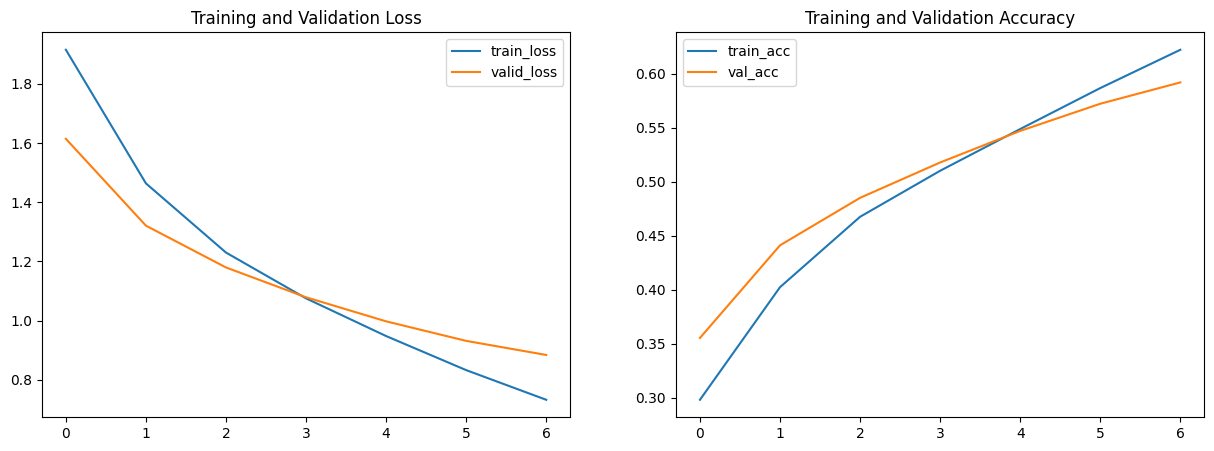

In [34]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

# losses
ax1.plot(epoch_train_losses, label = "train_loss")
ax1.plot(epoch_val_losses, label = "valid_loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()

# accuracies
ax2.plot(epoch_train_accuracies, label = "train_acc")
ax2.plot(epoch_val_accuracies, label = "val_acc")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
plt.show()

In [35]:
def translate_sentence(input_sentence, decoded_max_len):
    # Tokenize the input sequence
    tokenized_input_sentence = eng_vectorization([input_sentence])

    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)

    # Get the encoder outputs (including hidden states)
    en_outputs = encoder(tf.constant(tokenized_input_sentence), en_initial_states)

    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]

    # Create the decoder input, the sos token
    de_input = tf.constant([[fra_vectorization.get_vocabulary().index("[start]")]])

    out_words = []

    while True:
        # Decode and get the output probabilities
        de_output, de_state_h, de_state_c = decoder(
            de_input, (de_state_h, de_state_c))

        # Select the word with the highest probability
        de_input = tf.argmax(de_output, -1)

        # Append the word to the predicted output
        out_words.append(fra_index_lookup[de_input.numpy()[0][0]])

        # Finish when eos token is found or the max length is reached
        if out_words[-1] == "[end]" or len(out_words) >= decoded_max_len:
            break

    print("Input :", input_sentence[0])
    print("Predicted translation :", " ".join(out_words))

In [36]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]

fra_vocab = fra_vectorization.get_vocabulary()
fra_index_lookup = dict(zip(range(len(fra_vocab)), fra_vocab))

for _ in range(30):

    # Choose a random index
    random_index = random.randint(0, len(test_eng_texts) - 1)

    input_text = test_eng_texts[random_index]
    target_text = test_fra_texts[random_index]
    test_sents = [input_text]

    translate_sentence(test_sents, 20)
    print("Actual translation :", target_text)
    print()

Input : She had a headache from lack of sleep.
Predicted translation : elle a eu un tres bon de la chance pour le faire . [end]
Actual translation : [start] Elle avait un mal de tête dû au manque de sommeil. [end]

Input : I don't like people looking at me.
Predicted translation : je naime pas la facon de jouer . [end]
Actual translation : [start] Je n'apprécie pas que les gens me regardent. [end]

Input : Bring me another fork, please.
Predicted translation : apportezmoi une autre tasse de cafe ! [end]
Actual translation : [start] Apportez-moi une autre fourchette, je vous en prie. [end]

Input : Where are the apples?
Predicted translation : ou sont les pommes ? [end]
Actual translation : [start] Où sont les pommes ? [end]

Input : If he is innocent, it follows that his wife is guilty.
Predicted translation : sil est a la derniere fois que tu [UNK] . [end]
Actual translation : [start] S'il est innocent, c'est donc sa femme qui est coupable. [end]

Input : Do you know who is looking at

The previously described model based on RNNs has a serious problem when working with long sequences, because the information of the first tokens is lost or diluted as more tokens are processed. The context vector has been given the responsibility of encoding all the information in a given source sentence in to a vector of few hundred elements. it made it challenging for the models to deal with long sentences. A solution was proposed in Bahdanau et al., 2014 [4] and Luong et al., 2015,[5].


They introduce a technique called "Attention", which highly improved the quality of machine translation systems. Attention allows the model to focus on the relevant parts of the input sequence as needed, accessing to all the past hidden states of the encoder, instead of just the last one. At each decoding step, the decoder gets to look at any particular state of the encoder and can selectively pick out specific elements from that sequence to produce the output. We will focus on the Luong perspective.


In [37]:
class Attention(tf.keras.Model):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()

        self.wa = layers.Dense(hidden_dim)

    def call(self, decoder_output, encoder_output):
        # General score function: decoder_output (dot) (Wa (dot) encoder_output)

        # Decoder output is fed in one word at a time to attention layer
        # decoder_output has shape: (batch_size, 1, hidden_dim)

        # encoder_output has shape: (batch_size, sequence_length, hidden_dim)

        # => score has shape: (batch_size, 1, sequence_length)
        score = tf.matmul(
            decoder_output,
            self.wa(encoder_output), transpose_b = True
        )

        # alignment = softmax(score)
        attention = tf.keras.activations.softmax(score, axis = -1)
        # (batch_size, 1, sequence_length)

        # context vector is the weighted average sum of encoder output
        context = tf.matmul(attention, encoder_output)
        # (batch_size, 1, hidden_dim)

        return context, attention

For Decoder network with Attention mechanism
- Creating the encoder hidden states as usual, one for every input token
- Applying  a LSTM to produce a new hidden state, taking its previous hidden state and the target output from the previous time step
- Calculating the attention scores as described previously
- Calculating the context vector
- Now the context vector is concatenated with the decoder hidden state we generated previously, then it is passed through a linear layer which acts as a classifier for us to obtain the probability scores of the next predicted word

In [38]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()

        self.hidden_dim = hidden_dim

        self.attention = Attention(hidden_dim)

        self.embedding = layers.Embedding(vocab_size, embedding_dim)

        self.lstm = layers.LSTM(
            hidden_dim, return_sequences = True, return_state = True)

        self.wc = layers.Dense(hidden_dim, activation = "tanh")
        self.ws = layers.Dense(vocab_size)

    def call(self, input_sequence, state, encoder_output):
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # input_sequence shape: (batch_size, 1)

        embed = self.embedding(input_sequence)
        # embed shape: (batch_size, 1, embedding_dim)

        lstm_out, state_h, state_c = self.lstm(embed, initial_state = state)
        # lstm_out shape: (batch_size, 1, hidden_dim)

        # Use self.attention to compute the context and alignment vectors
        # context shape: (batch_size, 1, hidden_dim)
        # alignment shape: (batch_size, 1, sequence_length)
        context, attention = self.attention(lstm_out, encoder_output)

        # Combine the context vector and the LSTM output
        # Before combining, both have shape of (batch_size, 1, hidden_dim),
        # so let;s squeeze the axis 1 first
        # Shape after combining (batch_size, 2 * hidden_dim)
        lstm_out = tf.concat(
            [tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

        # lstm_out now has shape (batch_size, hidden_dim)
        lstm_out = self.wc(lstm_out)

        # Converted back to vocabulary space: (batch_size, vocab_size)
        outputs = self.ws(lstm_out)

        return outputs, state_h, state_c, attention

Decoder is tested

In [39]:
embedding_dim = 128
hidden_units = 256

encoder = Encoder(vocab_inp_size, embedding_dim, hidden_units)
decoder = Decoder(vocab_out_size, embedding_dim, hidden_units)

# Call the encoder and then the decoder
initial_state = encoder.init_states(1)

encoder_outputs = encoder(tf.constant([[1, 2, 3, 4, 5]]), initial_state)

decoder_outputs = decoder(tf.constant(
    [[2]]), encoder_outputs[1:], encoder_outputs[0])

decoder_outputs[0].shape

TensorShape([1, 15000])

Now we can define our step train function, to train a batch data. It is very similar to the one we coded for the seq2seq model without attention but this time we pass all the hidden states returned by the encoder to the decoder. And we need to create a loop to iterate through the target sequences, calling the decoder for each one and calculating the loss function comparing the decoder output to the expected target.

In [40]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    loss = 0.
    acc = 0.
    logits = None

    en_initial_states = encoder.init_states(batch_size)

    with tf.GradientTape() as tape:
        en_outputs = encoder(input_seq, en_initial_states)

        de_state_h, de_state_c = en_outputs[1:]

        # Shape of target_seq_out (batch_size, sequence_length)

        # Iterate over each word in the target sequence
        for i in range(target_seq_out.shape[1]):

            # Input to the decoder must have shape of (batch_size, 1)
            # so we need to expand one dimension
            # (batch_size, ) -> (batch_size, 1)
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)

            logit, de_state_h, de_state_c, _ = decoder(
                decoder_in, (de_state_h, de_state_c), en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)

            # Store the logits to calculate the accuracy
            # Shape (batch_size, vocab_size) -> (batch_size, 1, vocab_size)
            logit = K.expand_dims(logit, axis = 1)

            # Next word predicted in the output
            # logit shape: (batch_size, 1, vocab_size)

            if logits is None:
                logits = logit
            else:
                logits = K.concatenate((logits, logit), axis = 1)

        # Logits of complete output
        # logits shape: (batch_size, sequence_length, vocab_size)

        # Calculate the accuracy for the batch data
        acc = accuracy_fn(target_seq_out, logits)

    # Update the parameters and the optimizer
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1], acc

similarly validation step is defined without optimizer and gradients updation

In [41]:
@tf.function
def valid_step(val_input_seq, val_target_seq_in, val_target_seq_out, en_initial_states):
    loss = 0.
    acc = 0.
    logits = None

    # Get the encoder outputs
    en_outputs = encoder(val_input_seq, en_initial_states)
    de_state_h, de_state_c = en_outputs[1:]

    # Shape of target_seq_out (batch_size, sequence_length)

    # Iterate over each word in the target sequence
    for i in range(val_target_seq_out.shape[1]):
        # Input to the decoder must have shape of (batch_size, 1)
        # so we need to expand one dimension
        decoder_in = tf.expand_dims(val_target_seq_in[:, i], 1)

        logit, de_state_h, de_state_c, _ = decoder(
            decoder_in, (de_state_h, de_state_c), en_outputs[0])

        # The loss is now accumulated through the whole batch
        loss += loss_func(val_target_seq_out[:, i], logit)

        # Store the logits to calculate the accuracy
        logit = tf.expand_dims(logit, axis=1)

        if logits is None:
            logits = logit
        else:
            logits = tf.concat((logits, logit), axis=1)

    # Calculate the accuracy for the batch data
    acc = accuracy_fn(val_target_seq_out, logits)

    return loss / val_target_seq_out.shape[1], acc


Creating an Adam optimizer

In [42]:
optimizer = tf.keras.optimizers.Adam(clipnorm = 5.0)

In [43]:
epoch_train_losses = []
epoch_train_accuracies = []

epoch_val_losses = []
epoch_val_accuracies = []

num_epochs = 7

for epochs in range(num_epochs):

    en_initial_states = encoder.init_states(batch_size)

    train_losses = []
    train_accuracies = []

    for i, (input_seq, target_seq_in, target_seq_out) in enumerate(train_ds.take(-1)):
        loss, accuracy = train_step(
            input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer,)

        train_losses.append(loss)
        train_accuracies.append(accuracy)

    # Calculate average training loss and accuracy
    avg_train_loss = tf.reduce_mean(train_losses)
    avg_train_accuracy = tf.reduce_mean(train_accuracies)

    epoch_train_losses.append(avg_train_loss)
    epoch_train_accuracies.append(avg_train_accuracy)

    val_losses = []
    val_accuracies = []

    for j, (val_input_seq, val_target_seq_in, val_target_seq_out) in enumerate(val_ds.take(-1)):
        valid_loss, valid_accuracy = valid_step(
            val_input_seq, val_target_seq_in, val_target_seq_out, en_initial_states)

        val_losses.append(valid_loss)
        val_accuracies.append(valid_accuracy)

    # Calculate average validation loss and accuracy
    avg_val_loss = tf.reduce_mean(val_losses)
    avg_val_accuracy = tf.reduce_mean(val_accuracies)

    epoch_val_losses.append(avg_val_loss)
    epoch_val_accuracies.append(avg_val_accuracy)

    print("Epoch {} "
          "Avg Train Loss: {:.4f} "
          "Avg Train Acc: {:.4f}  "
          "Avg Validation Loss: {:.4f}  "
          "Avg Val Acc: {:.4f}".format(epochs + 1,
                                  avg_train_loss.numpy(),
                                  avg_train_accuracy.numpy(),
                                  avg_val_loss.numpy(),
                                  avg_val_accuracy.numpy())
    )

Epoch 1 Avg Train Loss: 1.9391 Avg Train Acc: 0.3080  Avg Validation Loss: 1.3537  Avg Val Acc: 0.4473
Epoch 2 Avg Train Loss: 1.0841 Avg Train Acc: 0.5477  Avg Validation Loss: 0.8805  Avg Val Acc: 0.6120
Epoch 3 Avg Train Loss: 0.7573 Avg Train Acc: 0.6488  Avg Validation Loss: 0.7149  Avg Val Acc: 0.6657
Epoch 4 Avg Train Loss: 0.6012 Avg Train Acc: 0.6967  Avg Validation Loss: 0.6413  Avg Val Acc: 0.6911
Epoch 5 Avg Train Loss: 0.5073 Avg Train Acc: 0.7287  Avg Validation Loss: 0.6040  Avg Val Acc: 0.7061
Epoch 6 Avg Train Loss: 0.4423 Avg Train Acc: 0.7532  Avg Validation Loss: 0.5809  Avg Val Acc: 0.7155
Epoch 7 Avg Train Loss: 0.3927 Avg Train Acc: 0.7739  Avg Validation Loss: 0.5683  Avg Val Acc: 0.7221


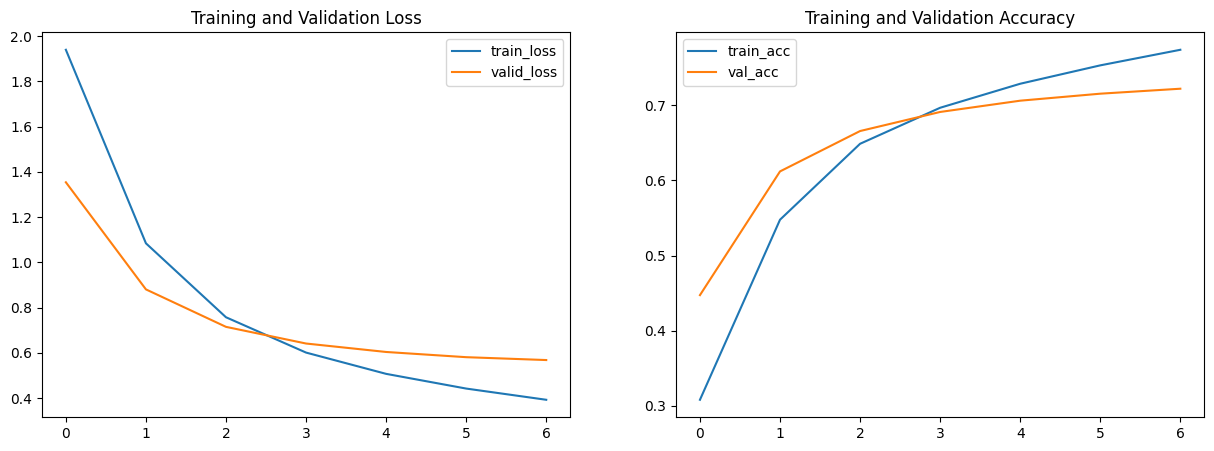

In [44]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

# losses
ax1.plot(epoch_train_losses, label = "train_loss")
ax1.plot(epoch_val_losses, label = "valid_loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()

# accuracies
ax2.plot(epoch_train_accuracies, label = "train_acc")
ax2.plot(epoch_val_accuracies, label = "val_acc")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
plt.show()

Defining a function for translation and obtaining attention weights

In [45]:
def translate_sentence_with_attention(input_sentence, encoder, decoded_max_len):
    # Tokenize the input text
    tokenized_input_sentence = eng_vectorization([input_sentence])

    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)

    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(tokenized_input_sentence), en_initial_states)

    # Set the decoder input to the sos token
    de_input = tf.constant([[fra_vectorization.get_vocabulary().index("[start]")]])

    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]

    out_words = []
    attention_weights = []

    fra_vocab = fra_vectorization.get_vocabulary()
    fra_index_lookup = dict(zip(range(len(fra_vocab)), fra_vocab))

    while True:
        # Get the decoder with attention output
        de_output, de_state_h, de_state_c, attention = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])

        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)

        # Detokenize the output
        out_words.append(fra_index_lookup[de_input.numpy()[0][0]])

        # Save the aligment matrix
        attention_weights.append(attention.numpy())

        if out_words[-1] == "[end]" or len(out_words) >= decoded_max_len:
            break

    print("Input :", input_sentence)

    # Join the output words
    print("Predicted translation :", " ".join(out_words))

    return np.array(attention_weights), input_sentence.split(" "), out_words

Translating a few test sentences

In [46]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]

for _ in range(30):
    # Choose a random index
    random_index = random.randint(0, len(test_eng_texts) - 1)

    input_text = test_eng_texts[random_index]
    target_text = test_fra_texts[random_index]
    test_sents = [input_text]

    translate_sentence_with_attention(test_sents[0], encoder, 20)
    print("Actual translation :", target_text)
    print()

Input : The rules were recently relaxed.
Predicted translation : les regles etaient importants . [end]
Actual translation : [start] Les règles ont été récemment assouplies. [end]

Input : I should like to go for a swim.
Predicted translation : jaurais du aimer en aller nager . [end]
Actual translation : [start] Je voudrais aller nager. [end]

Input : You have to take a shower.
Predicted translation : tu dois prendre une averse . [end]
Actual translation : [start] Tu dois prendre une douche. [end]

Input : I love you just the way you are.
Predicted translation : je taime juste sur le chemin que tu es . [end]
Actual translation : [start] Je t'aime juste comme tu es. [end]

Input : What year were you born?
Predicted translation : en quelle annee etesvous nes ? [end]
Actual translation : [start] En quelle année es-tu né ? [end]

Input : Faith can move mountains.
Predicted translation : la foi peut bouger des montagnes . [end]
Actual translation : [start] La foi peut soulever des montagnes.

Plotting attention heatmaps for source and prediction pairs

Input : you have a lot of strange ideas .
Predicted translation : tu as beaucoup didees etranges . [end]


<ipython-input-47-37920296982a>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + source, rotation=90)
<ipython-input-47-37920296982a>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + prediction)


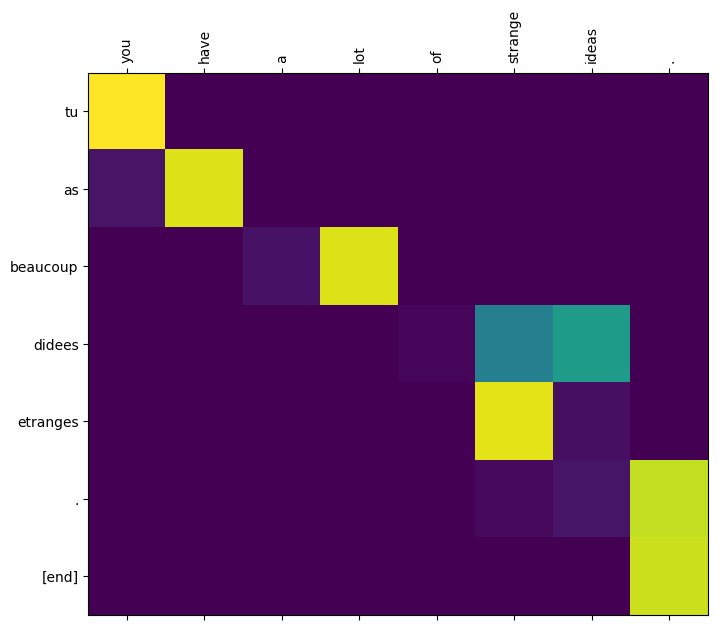

In [47]:
# test_sents = ["You are young and strong ."]
# test_sents = ["The train was on time ."]
# test_sents= ["It is a difficult language ."]
# test_sents = ["you are taller than me ."]
test_sents = ["you have a lot of strange ideas ."]

# Create the figure to plot in
fig = plt.figure(figsize = (8, 8))

for i, test_sent in enumerate(test_sents):
    # Call the predict function to get the translation
    attention_weights, source, prediction = translate_sentence_with_attention(test_sent, encoder, 20)
    attention = np.squeeze(attention_weights, (1, 2))

    # Create a subplot
    ax = fig.add_subplot(1, 1, i+1)
    ax.matshow(attention[:len(prediction), :len(source)], cmap = "viridis")
    ax.set_xticklabels([""] + source, rotation=90)
    ax.set_yticklabels([""] + prediction)

plt.show()